#<center> Portfolio Optimization Methods Through BTC under Parametic and Non-Parametic Value-at-Risk(VaR) Risk Measures <center>

##Installing & Importing Packages

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install PyPortfolioOpt;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import math
from scipy.stats import chi2
import functools as ft
from scipy.stats import norm
import pandas_datareader.data as web
from datetime import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier


##Importing Data

In [ ]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'XLE', 'EURUSD=X', 'LQD','SI=F' ,'BTC-USD']

In [ ]:
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 1, 1)

In [ ]:
df = web.DataReader(tickers, data_source='yahoo', start=start_date, end=end_date)
df = df['Adj Close']
df

Symbols,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F,BTC-USD
Date,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,1.209863,NaN,NaN,314.248993
2015-01-02,24.644016,41.013313,15.426000,58.140224,1.208941,94.787590,15.734000,315.032013
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281.082001
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.195007
2015-01-05,23.949757,40.636166,15.109500,55.735062,1.194643,95.175156,16.179001,274.473999
...,...,...,...,...,...,...,...,...
2021-12-29,178.640778,340.451477,169.201004,54.560398,1.131478,130.113998,22.848000,46444.710938
2021-12-30,177.465622,337.832977,168.644501,54.227356,1.136015,130.635651,23.028000,47178.125000
2021-12-31,176.838242,334.846130,166.716995,54.364491,1.132503,130.438797,23.327999,46306.445312


##Data Wrangling

In [ ]:
#Couting missing values
df.isnull().sum()

Symbols
AAPL        796
MSFT        796
AMZN        796
XLE         796
EURUSD=X    735
LQD         796
SI=F        799
BTC-USD       0
dtype: int64

In [ ]:
#Total number of missing values
df.isnull().sum().sum()

5514

In [ ]:
#Total number of non-missing
df.notnull().sum().sum()

14958

In [ ]:
#Dropping missing values which are non-business working days
df = df.dropna(axis = 0)

In [ ]:
#Calculating returns df
returns_df = (df.pct_change()).dropna()

In [ ]:
#prices data frame without BTC
df_no_BTC = df.drop('BTC-USD', axis=1)

##Descriptive Statistics

In [ ]:
#Basic summary statistics function
def summary_stats(df = 'Pandas DataFrame'):
  """
Description of the function 
  """
  description = df.describe()
  description = ((description.reset_index().T.reset_index().T).reset_index(drop=True))
  description = description.drop(labels=1).reset_index(drop=True)
  print("Statistical summary of the data:\n")
  print(tabulate(description, headers='firstrow', tablefmt='fancy_grid', stralign="middle"))

In [ ]:
#Summary statistics of the prices
summary_stats(df)

Statistical summary of the data:

╒═════╤═════════╤══════════╤══════════╤══════════╤══════════╤════════════╤══════════╤══════════╤═══════════╕
│   0 │   index │     AAPL │     MSFT │     AMZN │      XLE │   EURUSD=X │      LQD │     SI=F │   BTC-USD │
╞═════╪═════════╪══════════╪══════════╪══════════╪══════════╪════════════╪══════════╪══════════╪═══════════╡
│   1 │ mean    │  59.7358 │ 120.889  │  82.6652 │ 50.0372  │  1.13866   │ 109.444  │ 18.1858  │ 11272.8   │
├─────┼─────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────────┼──────────┼───────────┤
│   2 │ std     │  40.8978 │  80.3337 │  50.3375 │  8.19563 │  0.0460159 │  13.1303 │  3.85306 │ 15998.8   │
├─────┼─────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────────┼──────────┼───────────┤
│   3 │ min     │  20.9496 │  35.4349 │  14.3475 │ 21.0397  │  1.03905   │  92.2406 │ 11.735   │   178.103 │
├─────┼─────────┼──────────┼──────────┼──────────┼──────────┼────────────┼──────────┼─────────

In [ ]:
#Summary statistics of the returns
summary_stats(returns_df)

Statistical summary of the data:

╒═════╤═════════╤═════════════╤═════════════╤═════════════╤═════════════╤══════════════╤══════════════╤══════════════╤═════════════╕
│   0 │   index │        AAPL │        MSFT │        AMZN │         XLE │     EURUSD=X │          LQD │         SI=F │     BTC-USD │
╞═════╪═════════╪═════════════╪═════════════╪═════════════╪═════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│   1 │ mean    │  0.00146662 │  0.00152292 │  0.00175182 │  0.00017757 │ -2.78357e-05 │  0.000220141 │  0.000434363 │  0.00448424 │
├─────┼─────────┼─────────────┼─────────────┼─────────────┼─────────────┼──────────────┼──────────────┼──────────────┼─────────────┤
│   2 │ std     │  0.0197174  │  0.0183089  │  0.0208128  │  0.0209346  │  0.00534996  │  0.00532675  │  0.0189266   │  0.0502688  │
├─────┼─────────┼─────────────┼─────────────┼─────────────┼─────────────┼──────────────┼──────────────┼──────────────┼─────────────┤
│   3 │ min     │ -0.128647   │ -0.

In [ ]:
#returns correlation table
return_corr = returns_df.corr()
return_corr = ((return_corr.reset_index().T.reset_index().T).reset_index(drop=True))
print(tabulate(return_corr, headers='firstrow', tablefmt='fancy_grid', stralign="middle"))

╒═════╤═══════════╤═══════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═══════════╤═════════════╕
│   0 │   Symbols │      AAPL │        MSFT │       AMZN │        XLE │    EURUSD=X │       LQD │      SI=F │     BTC-USD │
╞═════╪═══════════╪═══════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═══════════╪═════════════╡
│   1 │ AAPL      │ 1         │  0.690381   │ 0.568369   │ 0.385006   │  0.0013394  │ 0.15029   │ 0.124928  │  0.117604   │
├─────┼───────────┼───────────┼─────────────┼────────────┼────────────┼─────────────┼───────────┼───────────┼─────────────┤
│   2 │ MSFT      │ 0.690381  │  1          │ 0.651064   │ 0.410743   │ -0.00386434 │ 0.165572  │ 0.104026  │  0.134442   │
├─────┼───────────┼───────────┼─────────────┼────────────┼────────────┼─────────────┼───────────┼───────────┼─────────────┤
│   3 │ AMZN      │ 0.568369  │  0.651064   │ 1          │ 0.251054   │  0.00351476 │ 0.107665  │ 0.0929406 │  0.0845332  │
├─────┼─

##Visualization

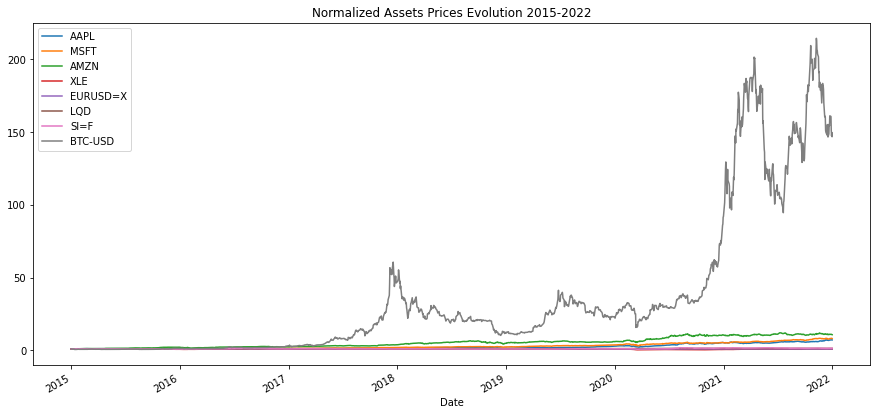

In [ ]:
##Visulaize the normalized prices evolution over time
normalized_prices_df = df.copy()
normalized_prices_df = normalized_prices_df / normalized_prices_df.iloc[0]
normalized_prices_df
normalized_prices_df['AAPL'].plot(label = 'AAPL', figsize = (15,7))
normalized_prices_df['MSFT'].plot(label = "MSFT")
normalized_prices_df['AMZN'].plot(label = "AMZN")
normalized_prices_df['XLE'].plot(label = "XLE")
normalized_prices_df['EURUSD=X'].plot(label = "EURUSD=X")
normalized_prices_df['LQD'].plot(label = "LQD")
normalized_prices_df['SI=F'].plot(label = "SI=F")
normalized_prices_df['BTC-USD'].plot(label = "BTC-USD")
plt.title('Normalized Assets Prices Evolution 2015-2022')
plt.legend()

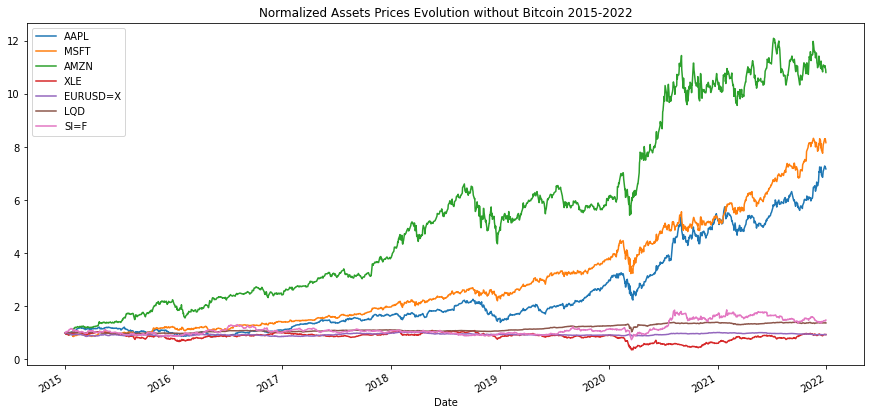

In [ ]:
##Visulaize the normalized prices evolution over time without Bitcoin
normalized_prices_df['AAPL'].plot(label = 'AAPL', figsize = (15,7))
normalized_prices_df['MSFT'].plot(label = "MSFT")
normalized_prices_df['AMZN'].plot(label = "AMZN")
normalized_prices_df['XLE'].plot(label = "XLE")
normalized_prices_df['EURUSD=X'].plot(label = "EURUSD=X")
normalized_prices_df['LQD'].plot(label = "LQD")
normalized_prices_df['SI=F'].plot(label = "SI=F")
plt.title('Normalized Assets Prices Evolution without Bitcoin 2015-2022')
plt.legend()

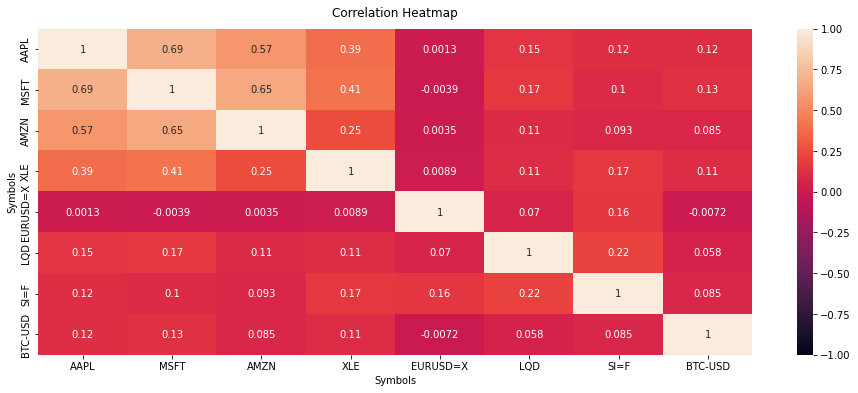

In [ ]:
##Correlations Heatmap
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(returns_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


##Modeling

### Value at Risk (VaR)

In [ ]:
#def historical_var(pct :'percentile'):
  #https://github.com/MBKraus/Python_Portfolio__VaR_Tool/blob/master/Portfolio_VaR_Toolv5.py


### Portfolios

#### 1.	Equally Weighted Portfolio (ωi = 1/N ∀ i) 

In [ ]:
all_tickers = df.columns.tolist()
tickers_without_BTC = df.columns.tolist()
tickers_without_BTC.remove('BTC-USD')

##### 1.1	Equally Weighted Portfolio without BTC (ωi = 1/N ∀ i) 

In [ ]:
weights = [round(1/len(tickers_without_BTC),3) for ticker in tickers_without_BTC]
weights

[0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143]

In [ ]:
#visulaizing the data frame with the weights and tickers
equally_weighted_pf = pd.DataFrame(index = tickers_without_BTC, columns = ['weights'], data = weights)
equally_weighted_pf.index.name='Assets'
equally_weighted_pf = ((equally_weighted_pf.reset_index().T.reset_index().T).reset_index(drop=True))
print(tabulate(equally_weighted_pf, headers='firstrow', tablefmt='fancy_grid', stralign="middle"))


╒═════╤══════════╤═══════════╕
│   0 │   Assets │   weights │
╞═════╪══════════╪═══════════╡
│   1 │ AAPL     │     0.143 │
├─────┼──────────┼───────────┤
│   2 │ MSFT     │     0.143 │
├─────┼──────────┼───────────┤
│   3 │ AMZN     │     0.143 │
├─────┼──────────┼───────────┤
│   4 │ XLE      │     0.143 │
├─────┼──────────┼───────────┤
│   5 │ EURUSD=X │     0.143 │
├─────┼──────────┼───────────┤
│   6 │ LQD      │     0.143 │
├─────┼──────────┼───────────┤
│   7 │ SI=F     │     0.143 │
╘═════╧══════════╧═══════════╛


In [ ]:
#portfolio construction
mu = mean_historical_return(df_no_BTC)
S = CovarianceShrinkage(df_no_BTC).ledoit_wolf()
ef = EfficientFrontier(mu, S)
#adding constraints to the weights
for x in range(len(tickers_without_BTC)):
  ef.add_constraint(lambda w : w[x] == 0.14285714285714285)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
equally_weighted_no_btc = pd.DataFrame(e, columns=['Equally_Weighted_Portfolio_no_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
equally_weighted_no_btc

Expected annual return: 19.4%
Annual volatility: 15.8%
Sharpe Ratio: 1.10


,Equally_Weighted_Portfolio_no_BTC
Expected Annual Return,0.193582
Annual volatility,0.157534
Sharp Ratio,1.101876


In [ ]:
Equally_weighted_no_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Equally_Weighted_Portfolio_no_BTC'])
Equally_weighted_no_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F
Equally_Weighted_Portfolio_no_BTC,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286,0.14286


##### 1.2	Equally Weighted Portfolio with BTC (ωi = 1/N ∀ i) 

In [ ]:
weights = [round(1/len(all_tickers),3) for ticker in all_tickers]
weights

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

In [ ]:
#visulaizing the data frame with the weights and tickers
equally_weighted_pf_no_btc = pd.DataFrame(index = all_tickers, columns = ['weights'], data = weights)
equally_weighted_pf_no_btc.index.name='Assets'
equally_weighted_pf_no_btc = ((equally_weighted_pf_no_btc.reset_index().T.reset_index().T).reset_index(drop=True))
print(tabulate(equally_weighted_pf_no_btc, headers='firstrow', tablefmt='fancy_grid', stralign="middle"))

╒═════╤══════════╤═══════════╕
│   0 │   Assets │   weights │
╞═════╪══════════╪═══════════╡
│   1 │ AAPL     │     0.125 │
├─────┼──────────┼───────────┤
│   2 │ MSFT     │     0.125 │
├─────┼──────────┼───────────┤
│   3 │ AMZN     │     0.125 │
├─────┼──────────┼───────────┤
│   4 │ XLE      │     0.125 │
├─────┼──────────┼───────────┤
│   5 │ EURUSD=X │     0.125 │
├─────┼──────────┼───────────┤
│   6 │ LQD      │     0.125 │
├─────┼──────────┼───────────┤
│   7 │ SI=F     │     0.125 │
├─────┼──────────┼───────────┤
│   8 │ BTC-USD  │     0.125 │
╘═════╧══════════╧═══════════╛


In [ ]:
#portfolio construction
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
#adding constraints to the weights
for x in range(len(tickers_without_BTC)):
  ef.add_constraint(lambda w : w[x] == 0.125)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
equally_weighted_with_btc = pd.DataFrame(e, columns=['Equally_Weighted_Portfolio_with_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
equally_weighted_with_btc

Expected annual return: 32.6%
Annual volatility: 18.2%
Sharpe Ratio: 1.68


,Equally_Weighted_Portfolio_with_BTC
Expected Annual Return,0.325749
Annual volatility,0.182311
Sharp Ratio,1.677074


In [ ]:
equally_weighted_with_btc_weights = pd.DataFrame(cleaned_weights, index = ['Equally_Weighted_Portfolio_with_BTC'])
equally_weighted_with_btc_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F,BTC-USD
Equally_Weighted_Portfolio_with_BTC,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125


##### 1.3	Equally Weighted Portfolio Optimization Results

In [ ]:
def optimizer_results(no_btc_results, no_btc_weights, with_btc_results, with_btc_weights):
  """
    This function gives us the merged and ready to present results of the portfolio with and without BTC

    Parameters:
      no_btc_results : the result of the portfolio optimization without BTC
        the result includes: Expected Annual Return, Annual volatility, and Sharp Ratio

      no_btc_weights : the weights of the optimized portfolio without BTC

      with_btc_results : the result of the portfolio optimization with BTC
        the result includes: Expected Annual Return, Annual volatility, and Sharp Ratio

      with_btc_weights : the weights of the optimized portfolio with BTC    


  """
  no_btc_df = pd.concat([no_btc_results, no_btc_weights.add_suffix('_weight').T], ignore_index = False)
  with_btc_df = pd.concat([with_btc_results, with_btc_weights.add_suffix('_weight').T], ignore_index = False)


  results = no_btc_df.merge(with_btc_df, how = 'right', left_index = True, right_index = True)
  results = results.round(3)
  results = results.fillna('')
  results.index.name = 'Performance/Weights'
  results = ((results.reset_index().T.reset_index().T).reset_index(drop=True))
  #return print(tabulate(results, tablefmt='fancy_grid', stralign="middle"))
  return print(tabulate(results, tablefmt='fancy_grid', stralign="middle"))

In [ ]:
optimizer_results(equally_weighted_no_btc, Equally_weighted_no_BTC_weights ,equally_weighted_with_btc, equally_weighted_with_btc_weights)

╒════╤════════════════════════╤═══════════════════════════════════╤═════════════════════════════════════╕
│  0 │ Performance/Weights    │ Equally_Weighted_Portfolio_no_BTC │ Equally_Weighted_Portfolio_with_BTC │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  1 │ Expected Annual Return │ 0.194                             │ 0.326                               │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  2 │ Annual volatility      │ 0.158                             │ 0.182                               │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  3 │ Sharp Ratio            │ 1.102                             │ 1.677                               │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  4 │ AAPL_weight            │ 0.143         

#### 2.	Long Only Portfolio (ωi   R : ωi ≥ 0; ∑ ωi = 1) 

##### 2.1	Long Only Portfolio without BTC (ωi   R : ωi ≥ 0; ∑ ωi = 1) 

In [ ]:
#portfolio construction
mu = mean_historical_return(df_no_BTC)
S = CovarianceShrinkage(df_no_BTC).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
long_only_no_btc = pd.DataFrame(e, columns=['Long_Only_Portfolio_no_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
long_only_no_btc

Expected annual return: 34.3%
Annual volatility: 21.3%
Sharpe Ratio: 1.51


,Long_Only_Portfolio_no_BTC
Expected Annual Return,0.342851
Annual volatility,0.213104
Sharp Ratio,1.514990


In [ ]:
long_no_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Long_Only_Portfolio_no_BTC'])
long_no_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F
Long_Only_Portfolio_no_BTC,0.11013,0.29688,0.35508,0.0,0.0,0.23791,0.0


##### 2.2	Long Only Portfolio with BTC (ωi   R : ωi ≥ 0; ∑ ωi = 1) 

In [ ]:
#portfolio construction
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
long_only_with_btc = pd.DataFrame(e, columns=['Long_Only_Portfolio_with_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
long_only_with_btc

Expected annual return: 56.6%
Annual volatility: 26.7%
Sharpe Ratio: 2.04


,Long_Only_Portfolio_with_BTC
Expected Annual Return,0.566185
Annual volatility,0.267479
Sharp Ratio,2.041975


In [ ]:
long_with_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Long_Only_Portfolio_with_BTC'])
long_with_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F,BTC-USD
Long_Only_Portfolio_with_BTC,0.07337,0.20936,0.33418,0.0,0.0,0.1535,0.0,0.2296


##### 2.3	Long Only Portfolio Optimization Results

In [ ]:
optimizer_results(long_only_no_btc, long_no_BTC_weights ,long_only_with_btc, long_with_BTC_weights)

╒════╤════════════════════════╤════════════════════════════╤══════════════════════════════╕
│  0 │ Performance/Weights    │ Long_Only_Portfolio_no_BTC │ Long_Only_Portfolio_with_BTC │
├────┼────────────────────────┼────────────────────────────┼──────────────────────────────┤
│  1 │ Expected Annual Return │ 0.343                      │ 0.566                        │
├────┼────────────────────────┼────────────────────────────┼──────────────────────────────┤
│  2 │ Annual volatility      │ 0.213                      │ 0.267                        │
├────┼────────────────────────┼────────────────────────────┼──────────────────────────────┤
│  3 │ Sharp Ratio            │ 1.515                      │ 2.042                        │
├────┼────────────────────────┼────────────────────────────┼──────────────────────────────┤
│  4 │ AAPL_weight            │ 0.11                       │ 0.073                        │
├────┼────────────────────────┼────────────────────────────┼────────────────────

####3.	Long-Short Portfolio (ωi ∈ R : max ω ϕi : −1 ≤ ωi ≤ 1; ∑ ωi = 1)

##### 3.1	Long-Short Portfolio without BTC (ωi ∈ R : max ω ϕi : −1 ≤ ωi ≤ 1; ∑ ωi = 1)

In [ ]:
#portfolio construction
mu = mean_historical_return(df_no_BTC)
S = CovarianceShrinkage(df_no_BTC).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
long_short_no_btc = pd.DataFrame(e, columns=['Long_Short_Portfolio_no_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
long_short_no_btc

Expected annual return: 90.1%
Annual volatility: 51.4%
Sharpe Ratio: 1.71


,Long_Short_Portfolio_no_BTC
Expected Annual Return,0.900758
Annual volatility,0.513596
Sharp Ratio,1.714885


In [ ]:
long_short_no_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Long_Short_Portfolio_no_BTC'])
long_short_no_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F
Long_Short_Portfolio_no_BTC,0.39038,0.87783,0.71157,-0.73476,-1.0,0.6664,0.08858


##### 3.2	Long-Short Portfolio with BTC (ωi ∈ R : max ω ϕi : −1 ≤ ωi ≤ 1; ∑ ωi = 1)

In [ ]:
#portfolio construction
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
long_short_with_btc = pd.DataFrame(e, columns=['Long_Short_Portfolio_with_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
long_short_with_btc

Expected annual return: 144.2%
Annual volatility: 64.2%
Sharpe Ratio: 2.22


,Long_Short_Portfolio_with_BTC
Expected Annual Return,1.442205
Annual volatility,0.641991
Sharp Ratio,2.215303


In [ ]:
long_short_with_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Long_Short_Portfolio_with_BTC'])
long_short_with_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F,BTC-USD
Long_Short_Portfolio_with_BTC,0.32959,0.71471,0.69391,-0.76963,-0.97798,0.48448,0.00178,0.52314


##### 3.3	Long-Short Portfolio Optimization Results

In [ ]:
optimizer_results(long_short_no_btc, long_short_no_BTC_weights ,long_short_with_btc, long_short_with_BTC_weights)

╒════╤════════════════════════╤═════════════════════════════╤═══════════════════════════════╕
│  0 │ Performance/Weights    │ Long_Short_Portfolio_no_BTC │ Long_Short_Portfolio_with_BTC │
├────┼────────────────────────┼─────────────────────────────┼───────────────────────────────┤
│  1 │ Expected Annual Return │ 0.901                       │ 1.442                         │
├────┼────────────────────────┼─────────────────────────────┼───────────────────────────────┤
│  2 │ Annual volatility      │ 0.514                       │ 0.642                         │
├────┼────────────────────────┼─────────────────────────────┼───────────────────────────────┤
│  3 │ Sharp Ratio            │ 1.715                       │ 2.215                         │
├────┼────────────────────────┼─────────────────────────────┼───────────────────────────────┤
│  4 │ AAPL_weight            │ 0.39                        │ 0.33                          │
├────┼────────────────────────┼─────────────────────────────

####4.	Minimum Variance Portfolio (ωi   R : min ω σP : ∑ ωi = 1) 

##### 4.1	Minimum Variance Portfolio without BTC (ωi   R : min ω σP : ∑ ωi = 1) )

In [ ]:
#portfolio construction
mu = mean_historical_return(df_no_BTC)
S = CovarianceShrinkage(df_no_BTC).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
min_variance_no_btc = pd.DataFrame(e, columns=['Minimum_Variance_Portfolio_no_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
min_variance_no_btc

Expected annual return: 3.2%
Annual volatility: 6.6%
Sharpe Ratio: 0.18


,Minimum_Variance_Portfolio_no_BTC
Expected Annual Return,0.032165
Annual volatility,0.066249
Sharp Ratio,0.183627


In [ ]:
min_variance_no_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Minimum_Variance_Portfolio_no_BTC'])
min_variance_no_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F
Minimum_Variance_Portfolio_no_BTC,0.00514,0.00664,0.01647,0.01752,0.48421,0.47001,0.0


##### 4.2	Minimum Variance Portfolio with BTC (ωi   R : min ω σP : ∑ ωi = 1) )

In [ ]:
#portfolio construction
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
min_variance_with_btc = pd.DataFrame(e, columns=['Minimum_Variance_Portfolio_with_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
min_variance_with_btc

Expected annual return: 3.6%
Annual volatility: 6.7%
Sharpe Ratio: 0.23


,Minimum_Variance_Portfolio_with_BTC
Expected Annual Return,0.035612
Annual volatility,0.067255
Sharp Ratio,0.232129


In [ ]:
min_variance_with_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Minimum_Variance_Portfolio_with_BTC'])
min_variance_with_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F,BTC-USD
Minimum_Variance_Portfolio_with_BTC,0.00522,0.00648,0.01684,0.01764,0.48323,0.46786,0.0,0.00273


##### 4.3	Minimum Variance Portfolio Optimization Results

In [ ]:
optimizer_results(min_variance_no_btc, min_variance_no_BTC_weights ,min_variance_with_btc, min_variance_with_BTC_weights)

╒════╤════════════════════════╤═══════════════════════════════════╤═════════════════════════════════════╕
│  0 │ Performance/Weights    │ Minimum_Variance_Portfolio_no_BTC │ Minimum_Variance_Portfolio_with_BTC │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  1 │ Expected Annual Return │ 0.032                             │ 0.036                               │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  2 │ Annual volatility      │ 0.066                             │ 0.067                               │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  3 │ Sharp Ratio            │ 0.184                             │ 0.232                               │
├────┼────────────────────────┼───────────────────────────────────┼─────────────────────────────────────┤
│  4 │ AAPL_weight            │ 0.005         

####5.	Semi-Constrained Max-Long Portfolio (ωi ∈ R : ωi ≤ 0.25; ∑ ωi = 1)

##### 5.1	Semi-Constrained Max-Long Portfolio without BTC (ωi ∈ R : ωi ≤ 0.25; ∑ ωi = 1)

In [ ]:
#portfolio construction
mu = mean_historical_return(df_no_BTC)
S = CovarianceShrinkage(df_no_BTC).ledoit_wolf()
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda x : x <= 0.25)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
semi_constrained_no_btc = pd.DataFrame(e, columns=['Semi_Constrained_Max_Long_Portfolio_no_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
semi_constrained_no_btc

Expected annual return: 31.5%
Annual volatility: 19.7%
Sharpe Ratio: 1.49


,Semi_Constrained_Max_Long_Portfolio_no_BTC
Expected Annual Return,0.314719
Annual volatility,0.197330
Sharp Ratio,1.493535


In [ ]:
semi_constrained_no_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Semi_Constrained_Max_Long_Portfolio_no_BTC'])
semi_constrained_no_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F
Semi_Constrained_Max_Long_Portfolio_no_BTC,0.21211,0.25,0.25,0.0,0.01394,0.25,0.02395


##### 5.2	Semi-Constrained Max-Long Portfolio with BTC (ωi ∈ R : ωi ≤ 0.25; ∑ ωi = 1)

In [ ]:
#portfolio construction
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda x : x <= 0.25)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
semi_constrained_with_btc = pd.DataFrame(e, columns=['Semi_Constrained_Max_Long_Portfolio_with_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
semi_constrained_with_btc

Expected annual return: 51.4%
Annual volatility: 24.3%
Sharpe Ratio: 2.04


,Semi_Constrained_Max_Long_Portfolio_with_BTC
Expected Annual Return,0.514223
Annual volatility,0.242584
Sharp Ratio,2.037330


In [ ]:
semi_constrained_with_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Semi_Constrained_Max_Long_Portfolio_with_BTC'])
semi_constrained_with_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F,BTC-USD
Semi_Constrained_Max_Long_Portfolio_with_BTC,0.08252,0.22344,0.25,0.0,0.0,0.23501,0.0,0.20904


##### 5.3	Semi-Constrained Max-Long Portfolio Optimization Results

In [ ]:
optimizer_results(semi_constrained_no_btc, semi_constrained_no_BTC_weights ,semi_constrained_with_btc, semi_constrained_with_BTC_weights)

╒════╤════════════════════════╤════════════════════════════════════════════╤══════════════════════════════════════════════╕
│  0 │ Performance/Weights    │ Semi_Constrained_Max_Long_Portfolio_no_BTC │ Semi_Constrained_Max_Long_Portfolio_with_BTC │
├────┼────────────────────────┼────────────────────────────────────────────┼──────────────────────────────────────────────┤
│  1 │ Expected Annual Return │ 0.315                                      │ 0.514                                        │
├────┼────────────────────────┼────────────────────────────────────────────┼──────────────────────────────────────────────┤
│  2 │ Annual volatility      │ 0.197                                      │ 0.243                                        │
├────┼────────────────────────┼────────────────────────────────────────────┼──────────────────────────────────────────────┤
│  3 │ Sharp Ratio            │ 1.494                                      │ 2.037                                        │
├────┼──

####6.	Fully Constrained Portfolio (ωi ∈ R : −0.25 ≤ ωi ≤ 0.25; ∑ ωi = 1)

##### 6.1	Fully Constrained Portfolio without BTC (ωi ∈ R : −0.25 ≤ ωi ≤ 0.25; ∑ ωi = 1)

In [ ]:
#portfolio construction
mu = mean_historical_return(df_no_BTC)
S = CovarianceShrinkage(df_no_BTC).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda x : x <= 0.25)
ef.add_constraint(lambda x : x >= -0.25)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
fully_constrained_no_btc = pd.DataFrame(e, columns=['Fully_Constrained_Portfolio_no_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
fully_constrained_no_btc

Expected annual return: 33.2%
Annual volatility: 19.3%
Sharpe Ratio: 1.62


,Fully_Constrained_Portfolio_no_BTC
Expected Annual Return,0.332316
Annual volatility,0.192778
Sharp Ratio,1.620076


In [ ]:
fully_constrained_no_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Fully_Constrained_Portfolio_no_BTC'])
fully_constrained_no_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F
Fully_Constrained_Portfolio_no_BTC,0.25,0.25,0.25,-0.23938,0.17872,0.25,0.06066


##### 6.2	Fully Constrained Portfolio with BTC (ωi ∈ R : −0.25 ≤ ωi ≤ 0.25; ∑ ωi = 1)

In [ ]:
#portfolio construction
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda x : x <= 0.25)
ef.add_constraint(lambda x : x >= -0.25)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
e = ef.portfolio_performance(verbose=True)
fully_constrained_with_btc = pd.DataFrame(e, columns=['Fully_Constrained_Portfolio_with_BTC'], index = ['Expected Annual Return', 'Annual volatility', 'Sharp Ratio'])
fully_constrained_with_btc

Expected annual return: 59.4%
Annual volatility: 26.5%
Sharpe Ratio: 2.17


,Fully_Constrained_Portfolio_with_BTC
Expected Annual Return,0.594300
Annual volatility,0.264824
Sharp Ratio,2.168609


In [ ]:
fully_constrained_with_BTC_weights = pd.DataFrame(cleaned_weights, index = ['Fully_Constrained_Portfolio_with_BTC'])
fully_constrained_with_BTC_weights

,AAPL,MSFT,AMZN,XLE,EURUSD=X,LQD,SI=F,BTC-USD
Fully_Constrained_Portfolio_with_BTC,0.20523,0.25,0.25,-0.25,0.05964,0.25,0.01063,0.2245


##### 6.3	Fully Constrained Portfolio Optimization Results

In [ ]:
optimizer_results(fully_constrained_no_btc, fully_constrained_no_BTC_weights , fully_constrained_with_btc, fully_constrained_with_BTC_weights)

╒════╤════════════════════════╤════════════════════════════════════╤══════════════════════════════════════╕
│  0 │ Performance/Weights    │ Fully_Constrained_Portfolio_no_BTC │ Fully_Constrained_Portfolio_with_BTC │
├────┼────────────────────────┼────────────────────────────────────┼──────────────────────────────────────┤
│  1 │ Expected Annual Return │ 0.332                              │ 0.594                                │
├────┼────────────────────────┼────────────────────────────────────┼──────────────────────────────────────┤
│  2 │ Annual volatility      │ 0.193                              │ 0.265                                │
├────┼────────────────────────┼────────────────────────────────────┼──────────────────────────────────────┤
│  3 │ Sharp Ratio            │ 1.62                               │ 2.169                                │
├────┼────────────────────────┼────────────────────────────────────┼──────────────────────────────────────┤
│  4 │ AAPL_weight          

#### All Portfolios Optmilization Results

In [ ]:
all_portfolios_performance = [
                              equally_weighted_no_btc,
                              equally_weighted_with_btc,
                              long_only_no_btc,
                              long_only_with_btc,
                              long_short_no_btc,
                              long_short_with_btc,
                              min_variance_no_btc,
                              min_variance_with_btc,
                              semi_constrained_no_btc,
                              semi_constrained_with_btc,
                              fully_constrained_no_btc,
                             fully_constrained_with_btc
                            ]

In [ ]:
#Visulizing performances

def visualizer_all(list_portfolios : 'list of all portfolios performance', title : 'graph_title', shared_xaxis = True, horizontal_size : 'widht size of the graph' = 18 , vertical_size : 'height of the graph' = 10 ):
  """
    This functions serves to visulize the performance of the different portfolio in one graph

    Parameters:
      list_portfolios : a list of all portfolios performances

      title : string of the graph title

    Returns:
      a bar plot of each portfolio performance

  """
  fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(horizontal_size, vertical_size), sharex=shared_xaxis, sharey=True)

  stepping = 0

  for n in range(0, 6, 1):

    axs[n, 0].barh(list(list_portfolios[stepping].index), list(list_portfolios[stepping].iloc[:,0]))
    axs[n, 0].set_title(list_portfolios[stepping].columns[0])

    axs[n, 1].barh(list(list_portfolios[stepping+1].index), list(list_portfolios[stepping+1].iloc[:,0]))
    axs[n, 1].set_title(list_portfolios[stepping+1].columns[0])

    stepping += 2
  
  fig.suptitle(title, size = 20) 

  fig.tight_layout()
  fig.subplots_adjust(top=0.88)
  plt.show()

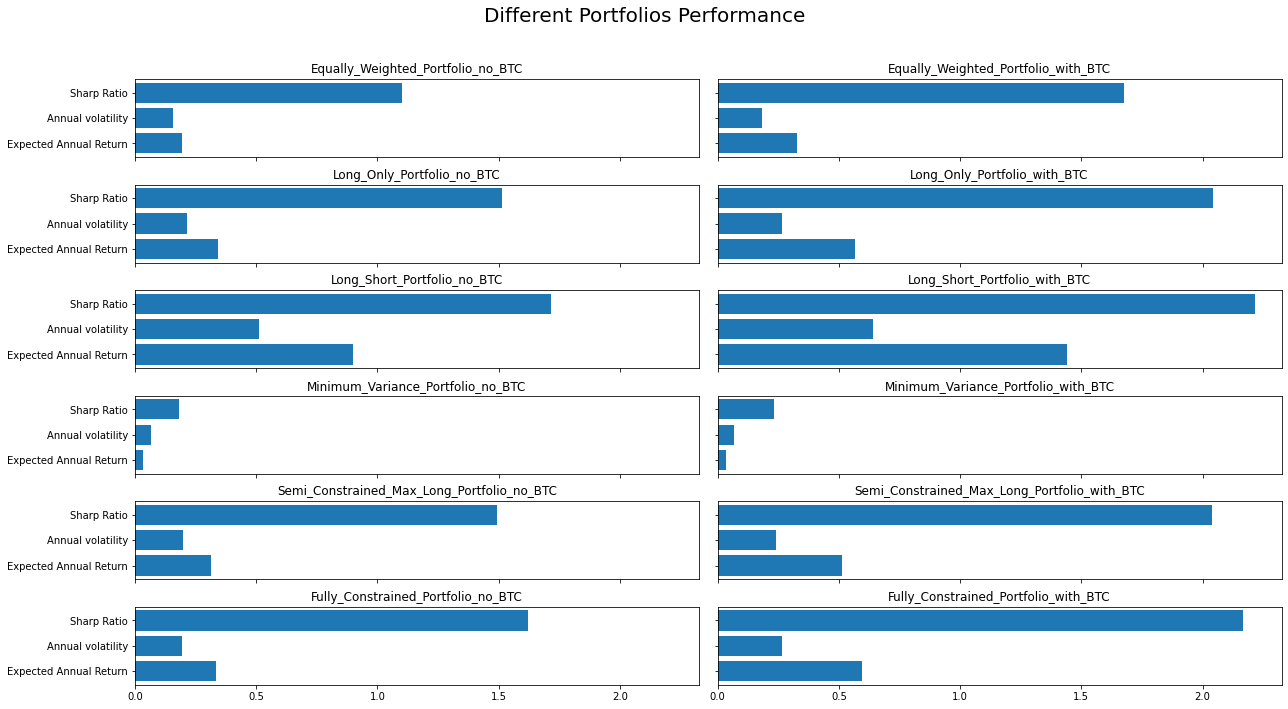

In [ ]:
visualizer_all(all_portfolios_performance, title = "Different Portfolios Performance")

In [ ]:
all_portfolios_weights = [
                              Equally_weighted_no_BTC_weights.T,
                              equally_weighted_with_btc_weights.T,
                              long_no_BTC_weights.T,
                              long_with_BTC_weights.T,
                              long_short_no_BTC_weights.T,
                              long_short_with_BTC_weights.T,
                             min_variance_no_BTC_weights.T,
                              min_variance_with_BTC_weights.T,
                              semi_constrained_no_BTC_weights.T,
                              semi_constrained_with_BTC_weights.T,
                              fully_constrained_no_BTC_weights.T,
                             fully_constrained_with_BTC_weights.T
                            ]

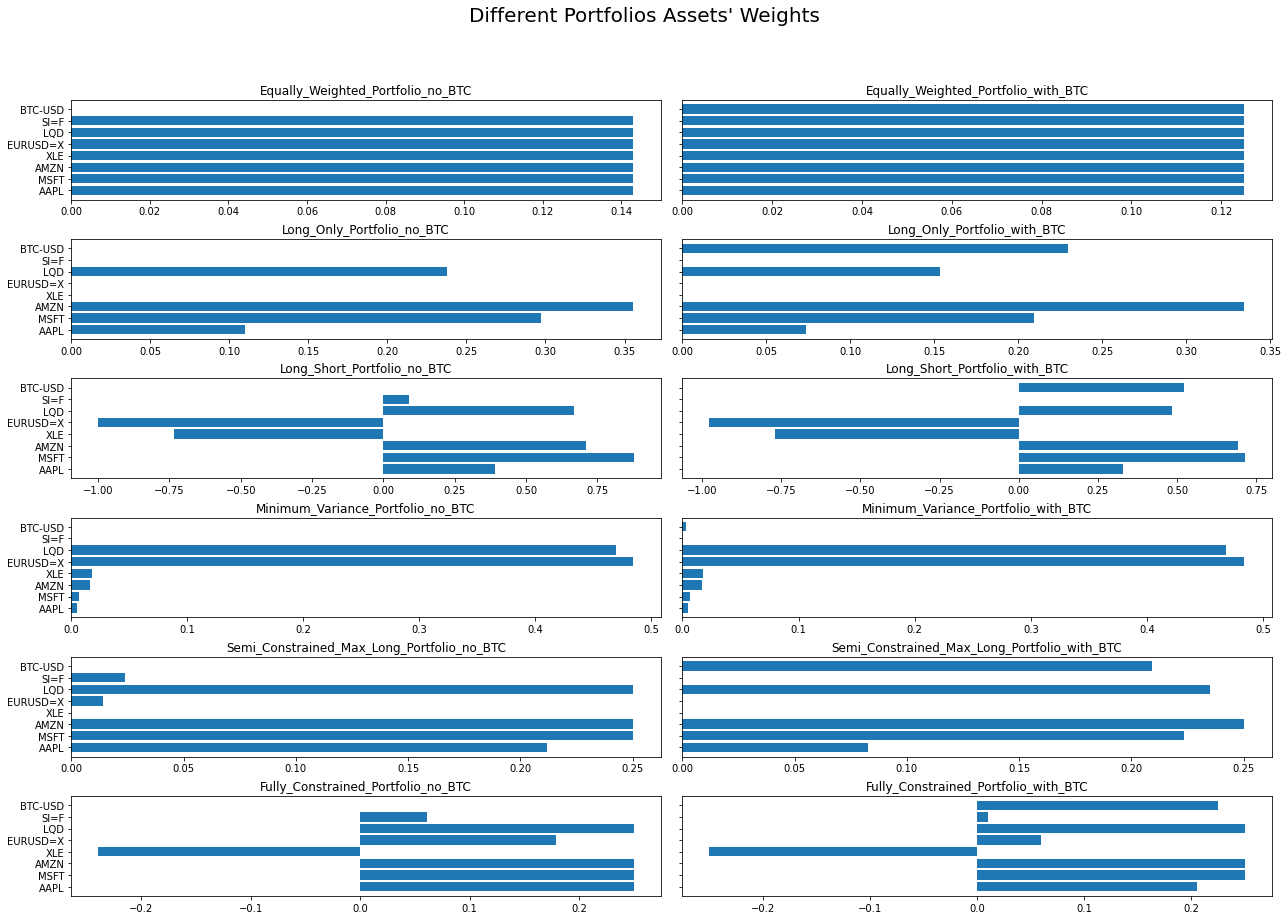

In [ ]:
visualizer_all(all_portfolios_weights, title = "Different Portfolios Assets' Weights", shared_xaxis = False, vertical_size = 13)

### Value at Risk (VaR)

Object Oriented Programming (OOP) will be used to implement the different VaR methods

In [ ]:
#def historical_var(pct :'percentile'):
  #https://github.com/MBKraus/Python_Portfolio__VaR_Tool/blob/master/Portfolio_VaR_Toolv5.py
  #https://github.com/KaihuaHuang/VaR/blob/master/VaR/VaR.py
  #

In [ ]:
class VaR:

    """The building block class that takes the necessary arguments to build the child VaR classes.

    Args:
        returns_df (Pandas DataFrame): Stocks Returns DataFrame.
        portfolio_weights (Pandas DataFrame): Stocks Weights DataFrame.
        confidence_interval (int) : significance interval between 0 & 1.
          
    Attributes:
        returns (Pandas DataFrame): Stocks Returns DataFrame.
        portfolio (Pandas DataFrame): Stocks Weights DataFrame.
        CI (int) : significance interval between 0 & 1.

    """
    def __init__(self, returns_df, portfolio_weights, confidence_interval):
      
      
      try:
        if (confidence_interval > 0 and confidence_interval < 1):
          self.CI = confidence_interval
        else:
          raise Exception("The confidence interval is not valid should be between 0 & 1", confidence_interval)
      except:
        raise Exception ("Please make sure to have an integer between 0 & 1")


      if not (isinstance(returns_df, pd.DataFrame) and isinstance(portfolio_weights, pd.DataFrame)):
        raise Exception("Please make sure to have DataFrame for reutrns and weights")
      
      if "BTC-USD" in list(portfolio_weights):
        pass
      else:
        returns_df = returns_df.drop('BTC-USD', axis=1)
        
      
      self.returns = returns_df
      #setting the weights but conserving same columns order as the returns
      self.weights = portfolio_weights[self.returns.columns]

      #setting the portfolio daily return through returns and weights
      self.portfolio_daily_return_df = self._porfolio_daily_return()

      #setting the portfolio individual assets cumulative daily returns
      self.assets_cumulative_daily_return =  self._cumulative_daily_returns()

    def _porfolio_daily_return(self):
        """This hidden function returns the portfolio daily return.

        Returns:
            It returns the portfolio daily return.

        """
        portfolio_daily_return_df = np.dot(self.returns, np.array(self.weights).T)
        return portfolio_daily_return_df

    
    def _cumulative_daily_returns(self):
        """This hidden function returns cumulative returns of individual assets of the portfolio.

        Returns:
            It returns the portfolio individual assets cumulative daily return.

        """
        cumulative_returns = self.returns.copy(deep=True)
        cumulative_returns = cumulative_returns.reset_index(drop=True)
        cumulative_returns.loc[-1] = [0]*len(cumulative_returns.columns)  
        cumulative_returns.index = cumulative_returns.index + 1  
        cumulative_returns = cumulative_returns.sort_index()  
        cumulative_returns = (cumulative_returns + 1).cumprod(axis=0)
        return cumulative_returns


    def parametric_variance_covariance_VaR(self, number_days = 252):
        """This function returns the parametric variance covariance VaR.

        Args:
            number_days(int) : number of working days.
                      Default value is 252 for a year.

        Returns:
            The percentage value of the parametric variance covariance VaR.

        """

        variance_covariance_matrix = np.cov(self.returns.T)

        portfolio_variance = np.dot(np.dot(np.array(self.weights), variance_covariance_matrix),self.weights.T)
        return(abs(norm.ppf(1-self.CI)*np.sqrt(portfolio_variance))*math.sqrt(number_days))[0][0]
        #return(abs(norm.ppf(1-self.CI)*np.sqrt(portfolio_variance)))[0][0]

    
    def historical_VaR(self, number_days = 252):
        """This function returns the historical VaR percentage.

        Args:
            number_days(int) : number of working days.
                      Default value is 252 for a year.

        Returns:
            The percentage value of the historical VaR.

        """
        historical_var = abs(np.percentile(self.portfolio_daily_return_df,100*(1-self.CI),interpolation = 'nearest'))*math.sqrt(number_days)
        return historical_var


    def monte_carlo_simulations_VaR(self, per_frequency, no_simulations) -> float:
        """This will returns the Monte Carlo VaR loss estimations.

        Args:
            per_frequency (str)  : daily/weekly/monthly/yearly/5years/10years
            no_simulations (int) : number of simulations; default is 1000 distinct simulations.
                      

        Returns:
            The percentage value of maximum loss the Monte Carlo Simulations VaR.
        """
        tickers = list(self.returns.columns)
        last_cumulative_returns = []
        for ticker_number in range(len(tickers)):
          last_cumulative_returns.append(self.assets_cumulative_daily_return.iloc[[-1],[ticker_number]])

        last_cumulative_returns = pd.concat(last_cumulative_returns,axis=1)
        last_cumulative_returns = np.array(last_cumulative_returns)

        #calculating the sigma
        #sigma = last_cumulative_returns.std()

        #multiplying cumulative returns by corresponding portfolio weights
        portfolio_expected_return = last_cumulative_returns.dot(self.weights.T)[0][0]
        
        #implementing the Monte Carlo Simulations
        frequency_switcher = {'DAILY':1,
                             'WEEKLY':5,
                             'YEARLY':252,
                             '5YEARS':252*5,
                             '10YEARS':252*10}

        per_frequency = str(per_frequency).upper()

        if per_frequency not in frequency_switcher.keys():
          raise Exception(f'Please insert one of these inputs {list(frequency_switcher.keys())} as the input of frequency')
        
        #looping through the number of simulations
        n_steps = frequency_switcher[per_frequency]
        
        sigma = self.portfolio_daily_return_df.std()*np.sqrt(n_steps)
        mean = self.portfolio_daily_return_df.mean()*n_steps
        np.random.seed(n_steps)

        all_simulations = []
        for simulation in range(no_simulations):
          #simulated_returns = (np.random.normal(mean/n_steps, sigma/math.sqrt(n_steps), n_steps))[-1]
          simulated_returns = (np.random.normal(mean, sigma, n_steps))[-1]
          all_simulations.append(simulated_returns)

        return np.percentile(all_simulations,1-self.CI)
        
    def reset_confidence_interval(self, confidence_interval):
        """This function resets the confidence interval of the VaR.

        Args:
            confidence_interval(int) : significance interval between 0 & 1.

        Returns:
            It resets the confidence intervale of the object.

        """

        try:
          if (confidence_interval > 0 and confidence_interval < 1):
            self.CI = confidence_interval
          else:
            raise Exception("The confidence interval is not valid should be between 0 & 1", confidence_interval)
        except:
          raise Exception ("Please make sure to have an integer between 0 & 1")
    


In [ ]:
def var_results_table(portfolio_weights):
        """This function returns a table of the different VaR methods run according to the different portfolio weights.

        Args:
            portfolio_weights(list) : list of DataFrames of the different portfolio weights.

        Returns:
            It returns a table with different VaR results on all tables

        """

        portfolio_names = []
        Monte_Carlo_VaR_95 = []
        Historical_VaR_95 = []
        variance_covariance_VaR_95 = []
        Monte_Carlo_VaR_99 = []
        Historical_VaR_99 = []
        variance_covariance_VaR_99 = [] 

        for portfolio in portfolio_weights:
          portfolio_name = portfolio.index[0]
          portfolio_VaR = VaR(returns_df,  portfolio, 0.95)
          MC_95 = portfolio_VaR.monte_carlo_simulations_VaR('YEARLY', 10000)
          HV_95 = portfolio_VaR.historical_VaR()
          VC_95 = portfolio_VaR.parametric_variance_covariance_VaR()
          #reseting confidence interval to 99%
          portfolio_VaR.reset_confidence_interval(0.99)
          MC_99 = portfolio_VaR.monte_carlo_simulations_VaR('YEARLY', 10000)
          HV_99 = portfolio_VaR.historical_VaR()
          VC_99 = portfolio_VaR.parametric_variance_covariance_VaR()
          #appending values to corresponding lists
          portfolio_names.append(portfolio_name)
          Monte_Carlo_VaR_95.append(MC_95)
          Historical_VaR_95.append(HV_95)
          variance_covariance_VaR_95.append(VC_95)
          Monte_Carlo_VaR_99.append(MC_99)
          Historical_VaR_99.append(HV_99)
          variance_covariance_VaR_99.append(VC_99)

        idx = pd.MultiIndex.from_product([["Equally Weighted", "Long Only", "Long Short", "Minimum Variance", "Semi Constrained", "Fully Constrained"],['No BTC', 'With BTC']], names=['Portfolio', 'BTC'])

        df1 = pd.DataFrame(data={"Historical VaR 95%" : Historical_VaR_95, "Parametric Variance_Covariance VaR 95%" : variance_covariance_VaR_95, "Monte Carlo Simulations VaR 95%": Monte_Carlo_VaR_95,
                              "Histroical VaR 99%" : Historical_VaR_99, "Parametric Variance_Covariance VaR 99%" : variance_covariance_VaR_99, "Monte Carlo Simulations VaR 99%" : Monte_Carlo_VaR_99},
                        index = portfolio_names).abs()

        #table for better consoidated table
        df2 = pd.DataFrame(data={"Historical VaR 95%" : Historical_VaR_95, "Parametric Variance_Covariance VaR 95%" : variance_covariance_VaR_95, "Monte Carlo Simulations VaR 95%": Monte_Carlo_VaR_95,
                              "Histroical VaR 99%" : Historical_VaR_99, "Parametric Variance_Covariance VaR 99%" : variance_covariance_VaR_99, "Monte Carlo Simulations VaR 99%" : Monte_Carlo_VaR_99},
                        index = idx).abs()
      
        return df1, df2.T


In [ ]:
all_portfolios_weights = [
                              Equally_weighted_no_BTC_weights,
                              equally_weighted_with_btc_weights,
                              long_no_BTC_weights,
                              long_with_BTC_weights,
                              long_short_no_BTC_weights,
                              long_short_with_BTC_weights,
                             min_variance_no_BTC_weights,
                              min_variance_with_BTC_weights,
                              semi_constrained_no_BTC_weights,
                              semi_constrained_with_BTC_weights,
                              fully_constrained_no_BTC_weights,
                             fully_constrained_with_BTC_weights
                            ]

In [ ]:
full_VaR_results, consolidated_VaR_results = var_results_table(all_portfolios_weights)

In [ ]:
consolidated_VaR_results = consolidated_VaR_results.round(3)
consolidated_VaR_results = consolidated_VaR_results.fillna('')
consolidated_VaR_results.index.name = 'Portfolios'
consolidated_VaR_results = ((consolidated_VaR_results.reset_index().T).reset_index())
print(tabulate(consolidated_VaR_results, tablefmt='fancy_grid', stralign="middle"))

╒════╤═══════════════════╤══════════╤════════════════════╤════════════════════════════════════════╤═════════════════════════════════╤════════════════════╤════════════════════════════════════════╤═════════════════════════════════╕
│  0 │ Portfolios        │          │ Historical VaR 95% │ Parametric Variance_Covariance VaR 95% │ Monte Carlo Simulations VaR 95% │ Histroical VaR 99% │ Parametric Variance_Covariance VaR 99% │ Monte Carlo Simulations VaR 99% │
├────┼───────────────────┼──────────┼────────────────────┼────────────────────────────────────────┼─────────────────────────────────┼────────────────────┼────────────────────────────────────────┼─────────────────────────────────┤
│  1 │ Equally Weighted  │ No BTC   │ 0.223              │ 0.261                                  │ 0.33                            │ 0.452              │ 0.369                                  │ 0.365                           │
├────┼───────────────────┼──────────┼────────────────────┼──────────────────────

### Full Results

In [ ]:
full_VaR_results

,Historical VaR 95%,Parametric Variance_Covariance VaR 95%,Monte Carlo Simulations VaR 95%,Histroical VaR 99%,Parametric Variance_Covariance VaR 99%,Monte Carlo Simulations VaR 99%
Equally_Weighted_Portfolio_no_BTC,0.223308,0.260824,0.330246,0.451670,0.368888,0.365032
Equally_Weighted_Portfolio_with_BTC,0.247402,0.300831,0.295231,0.481244,0.425471,0.335353
Long_Only_Portfolio_no_BTC,0.328352,0.352697,0.391953,0.572591,0.498826,0.438992
Long_Only_Portfolio_with_BTC,0.370441,0.441547,0.374090,0.667588,0.624489,0.432980
Long_Short_Portfolio_no_BTC,0.763373,0.845622,0.901874,1.317955,1.195980,1.014656
Long_Short_Portfolio_with_BTC,0.913361,1.055699,0.851676,1.657723,1.493095,0.992477
Minimum_Variance_Portfolio_no_BTC,0.088605,0.101111,0.170238,0.152226,0.143004,0.183724
Minimum_Variance_Portfolio_with_BTC,0.087579,0.101118,0.167142,0.151424,0.143013,0.180628
Semi_Constrained_Max_Long_Portfolio_no_BTC,0.303694,0.326649,0.362528,0.539053,0.461986,0.406094
Semi_Constrained_Max_Long_Portfolio_with_BTC,0.336923,0.400308,0.337397,0.616359,0.566163,0.390786


In [ ]:
portfolios_weights = pd.concat(all_portfolios_weights, join='outer', axis=0).fillna('')

In [ ]:
portfolios_performance = pd.concat(all_portfolios_performance, join='outer', axis=1).fillna('').T

In [ ]:
#Merging three datasets
dfs = [full_VaR_results, portfolios_weights, portfolios_performance]
df_final = (ft.reduce(lambda left, right: pd.merge(left, right, right_index=True, left_index=True), dfs)).T

In [ ]:
index_to_keep = ["Sharp Ratio","Expected Annual Return", "Annual volatility", "BTC-USD", "Historical VaR 95%", "Parametric Variance_Covariance VaR 95%", "Monte Carlo Simulations VaR 95%",
                 'Histroical VaR 99%', 'Parametric Variance_Covariance VaR 99%', 'Monte Carlo Simulations VaR 99%']
df_final = df_final.loc[index_to_keep]


Text(0.5, 1.05, 'Portfolios Optimization with BTC Results under VaR & MPT')

<Figure size 432x288 with 0 Axes>

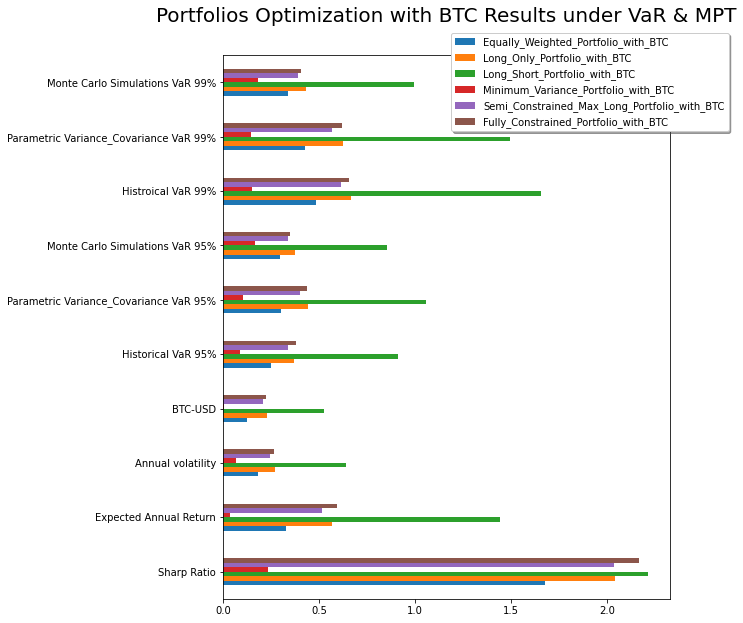

In [ ]:
plt.figure()
fig = df_final.plot.barh(figsize=(8, 10))
fig.legend(bbox_to_anchor=(0.5, 1.05),
          ncol=1, fancybox=True, shadow=True)
plt.title("Portfolios Optimization with BTC Results under VaR & MPT", size = 20, x=0.5, y=1.05)

Text(0.5, 1.05, 'BTC Portfolios Optimization VaR Focus')

<Figure size 432x288 with 0 Axes>

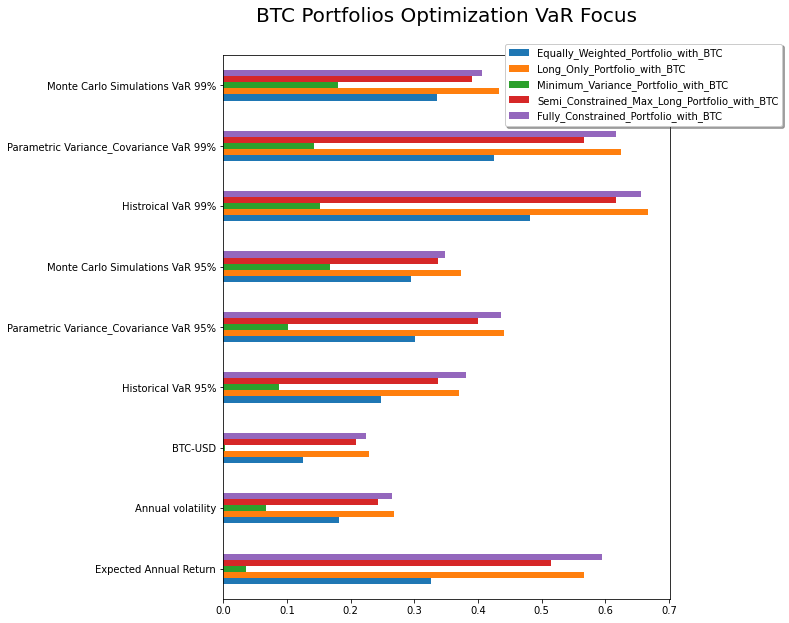

In [ ]:
plt.figure()
fig = (df_final.drop(index = "Sharp Ratio", columns = "Long_Short_Portfolio_with_BTC")).plot.barh(figsize=(8, 10))
fig.legend(bbox_to_anchor=(0.62, 0.86),
          ncol=1, fancybox=True, shadow=True)
plt.title("BTC Portfolios Optimization VaR Focus", size = 20, x=0.5, y=1.05)

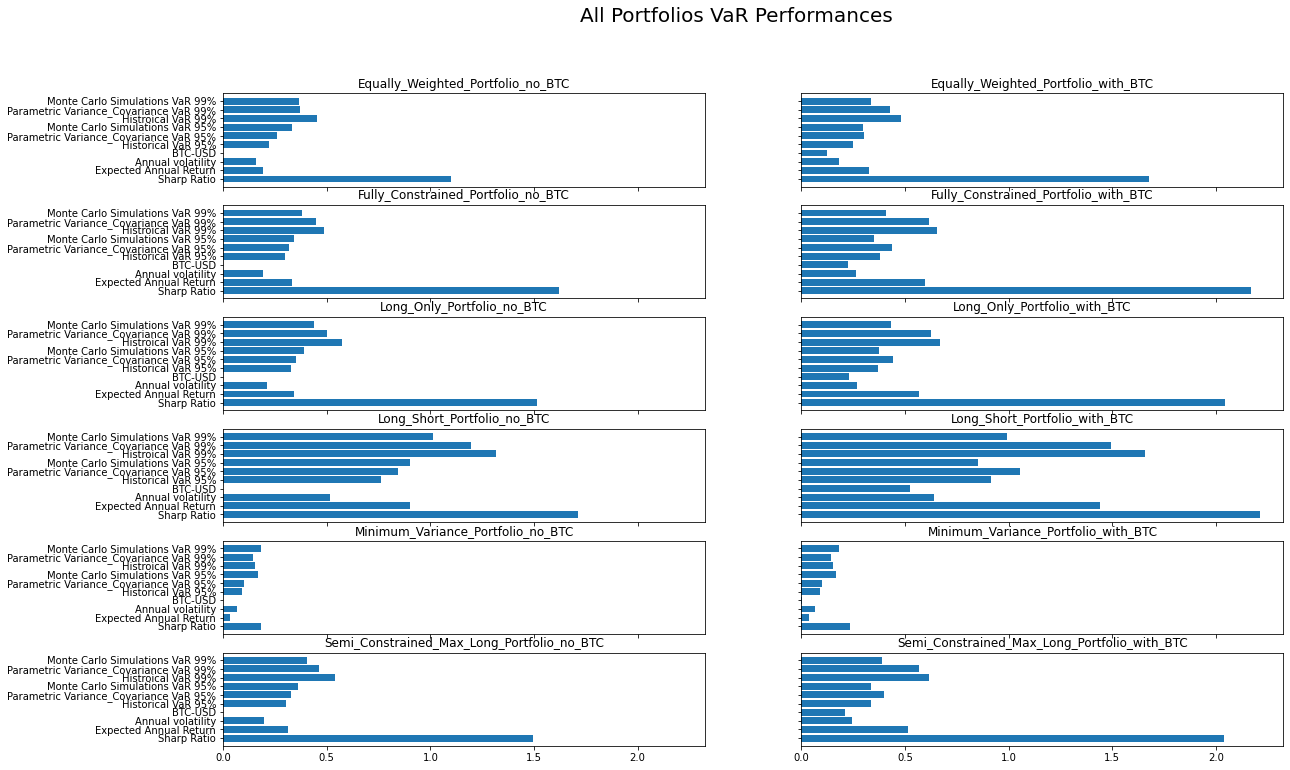

In [ ]:
df_final = df_final.replace('', 0)
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(19, 12), sharex=True, sharey=True)
BTC_columns = sorted([ column for column in df_final.columns if "with" in column])
no_BTC_columns = sorted(list([set(BTC_columns) ^ set(df_final.columns)][0]))

for n in range(len(BTC_columns)):
  axs[n, 0].barh(list(df_final.index), list(df_final.loc[:,no_BTC_columns[n]]))
  axs[n, 0].set_title(no_BTC_columns[n])
  axs[n, 1].barh(list(df_final.index), list(df_final.loc[:,BTC_columns[n]]))
  axs[n, 1].set_title(BTC_columns[n])

fig.suptitle("All Portfolios VaR Performances", size = 20) 
#fig.tight_layout()
#fig.subplots_adjust(top=0.88)
plt.show()




##Backtesting

### Kupiec's Proportion of Failures Test


Proportion of Failures (POF) Test

The pof function performs Kupiec's proportion of failures test.

The POF test is a likelihood ratio test proposed by Kupiec (1995) to assess if the proportion of failures (number of failures divided by number of observations) is consistent with the VaR confidence level.


In [ ]:
df_final = df_final.T
df_final

,Sharp Ratio,Expected Annual Return,Annual volatility,BTC-USD,Historical VaR 95%,Parametric Variance_Covariance VaR 95%,Monte Carlo Simulations VaR 95%,Histroical VaR 99%,Parametric Variance_Covariance VaR 99%,Monte Carlo Simulations VaR 99%
Equally_Weighted_Portfolio_no_BTC,1.101876,0.193582,0.157534,0.00000,0.223308,0.260824,0.330246,0.451670,0.368888,0.365032
Equally_Weighted_Portfolio_with_BTC,1.677074,0.325749,0.182311,0.12500,0.247402,0.300831,0.295231,0.481244,0.425471,0.335353
Long_Only_Portfolio_no_BTC,1.514990,0.342851,0.213104,0.00000,0.328352,0.352697,0.391953,0.572591,0.498826,0.438992
Long_Only_Portfolio_with_BTC,2.041975,0.566185,0.267479,0.22960,0.370441,0.441547,0.374090,0.667588,0.624489,0.432980
Long_Short_Portfolio_no_BTC,1.714885,0.900758,0.513596,0.00000,0.763373,0.845622,0.901874,1.317955,1.195980,1.014656
Long_Short_Portfolio_with_BTC,2.215303,1.442205,0.641991,0.52314,0.913361,1.055699,0.851676,1.657723,1.493095,0.992477
Minimum_Variance_Portfolio_no_BTC,0.183627,0.032165,0.066249,0.00000,0.088605,0.101111,0.170238,0.152226,0.143004,0.183724
Minimum_Variance_Portfolio_with_BTC,0.232129,0.035612,0.067255,0.00273,0.087579,0.101118,0.167142,0.151424,0.143013,0.180628
Semi_Constrained_Max_Long_Portfolio_no_BTC,1.493535,0.314719,0.197330,0.00000,0.303694,0.326649,0.362528,0.539053,0.461986,0.406094
Semi_Constrained_Max_Long_Portfolio_with_BTC,2.037330,0.514223,0.242584,0.20904,0.336923,0.400308,0.337397,0.616359,0.566163,0.390786


In [ ]:
VaR95 = (df_final.melt(id_vars = ['Expected Annual Return'], value_vars = ['Historical VaR 95%', 'Parametric Variance_Covariance VaR 95%', 'Monte Carlo Simulations VaR 95%'], value_name = 'VaR95%')).drop("variable", axis=1)
VaR99 = (df_final.melt(id_vars = ['Expected Annual Return'], value_vars = ['Histroical VaR 99%', 'Parametric Variance_Covariance VaR 99%', 'Monte Carlo Simulations VaR 99%'], value_name = 'VaR99%')).drop("variable", axis=1)

In [ ]:
VaR99['VaR95%'] = VaR95['VaR95%']
VaR_backtest_df = VaR99.copy()

In [ ]:
VaR_backtest_df['Violations_VaR_95%'] = np.where(VaR_backtest_df['VaR95%'] > VaR_backtest_df['Expected Annual Return'], 1, 0)
VaR_backtest_df['Violations_VaR_99%'] = np.where(VaR_backtest_df['VaR99%'] > VaR_backtest_df['Expected Annual Return'], 1, 0)

In [ ]:
VaR_backtest_df

,Expected Annual Return,VaR99%,VaR95%,Violations_VaR_95%,Violations_VaR_99%
0,0.193582,0.451670,0.223308,1,1
1,0.325749,0.481244,0.247402,0,1
2,0.342851,0.572591,0.328352,0,1
3,0.566185,0.667588,0.370441,0,1
4,0.900758,1.317955,0.763373,0,1
5,1.442205,1.657723,0.913361,0,1
6,0.032165,0.152226,0.088605,1,1
7,0.035612,0.151424,0.087579,1,1
8,0.314719,0.539053,0.303694,0,1
9,0.514223,0.616359,0.336923,0,1


In [ ]:
def kupiec_proportion_of_failures_test(VaR_viloations, VaR_confidence_interval=0.95, test_confidence_interval=0.95):
  """This test serves to backtest verify the VaR results obtained, using the proportion of failures ratio.
     The objective is to verify the consistency between the the proportions of failures and the violations proporsed by the model.

     Parameters:
            VaR_violations (Pandas Series) : Pandas Violations Series
            VaR_confidence_interval (float) : the confidence interval of the VaR test
            test_confidence_interval (float) : the confidence interval of the Kupiece's Test

      Returns:
        results (dict) : the test results

  """
  if isinstance(VaR_viloations, pd.core.series.Series):
    violations_v = VaR_viloations[VaR_viloations==1].count()
  
  total = VaR_viloations.shape[0]
  theta= 1-(violations_v/total)

  if violations_v < 0.001:
    V = -2*np.log((1-(violations_v/total))**(total))
  
  else:
    a = ((1-VaR_confidence_interval)**(violations_v)) * (VaR_confidence_interval**(total-violations_v))
        
    b = ((1-theta)**(violations_v)) * (theta**(total-violations_v))
        
    fact = math.factorial(total) / ( math.factorial(violations_v) * math.factorial(total-violations_v))
        
    numinator =a * fact
    denonimator = b * fact 
    
    V = -2*(np.log(numinator/denonimator))    

  chi_square_test = chi2.cdf(V,1)

  if chi_square_test < test_confidence_interval:
    return f"Fail to reject the null hypothesis. The VaR results are therefore consistent with the Kupiec Test. The chi square value is equal to {chi_square_test}"
  
  else:
    return f"Fail to accept the null hypothesis. The VaR results are therefore not consistent with the Kupiec Test. The chi square value is equal to {chi_square_test}"

In [ ]:
kupiec_proportion_of_failures_test(VaR_backtest_df['Violations_VaR_95%'], test_confidence_interval=0.95, VaR_confidence_interval=0.95)

'Fail to accept the null hypothesis. The VaR results are therefore not consistent with the Kupiec Test. The chi square value is equal to 0.9999999999486316'